

> # **DEEP LEARNING HW3**

---



---







In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE=128

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create empty lists for the sampled data and labels
sampled_data = []
sampled_labels = []

# Iterate over each class in CIFAR-10 (10 classes in total)
for class_index in range(10):
    # Get indices of all examples belonging to the current class
    class_indices = np.where(np.array(train_dataset.targets) == class_index)[0]
    # Randomly sample 1,000 indices uniformly at random from the class indices
    sampled_indices = np.random.choice(class_indices, size=1000, replace=False)
    # Append the sampled data and labels to the respective lists
    sampled_data.extend([train_dataset[i][0] for i in sampled_indices])
    sampled_labels.extend([train_dataset[i][1] for i in sampled_indices])

# Create a custom dataset using the sampled data and labels
custom_train_dataset = torch.utils.data.TensorDataset(torch.stack(sampled_data), torch.tensor(sampled_labels))

train_loader = torch.utils.data.DataLoader(custom_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Download and load the CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 100834535.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
classes=[0 for x in range(10)]
for i,(image,label) in enumerate(train_loader):
#     print(label)
    for i in label:
        classes[i] += 1
print(classes)

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [8]:
class ResnetModel:
    def __init__(self, itr, learningRate, alpha=0.2, mixup=False):
        import torch
        import torch.nn as nn
        import torch.optim as optim
        import torchvision.models as models
        self.itr=itr
        self.mixup=mixup
        self.lr=learningRate
        self.alpha=alpha
        self.model = models.resnet18(pretrained=False, num_classes=10)

        # Define the loss function
        self.criterion = nn.CrossEntropyLoss()

        # Define the optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=learningRate)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def mixup_data(self, images, labels, alpha=0.2):
      labels = self.one_hot_encode(labels) 
      batch_size = images.size(0)
      lam = np.random.beta(alpha, alpha)
      index = torch.randperm(batch_size)
      mixed_images = lam * images + (1 - lam) * images[index, :]
      mixed_labels = lam * labels + (1 - lam) * labels[index]
      return mixed_images, mixed_labels

    def one_hot_encode(self, labels):
        one_hot = torch.zeros(labels.size(0), 10)
        one_hot.scatter_(1, labels.unsqueeze(1), 1)
        return one_hot
        
    def train(self,trainData,testData):
        trainingLoss=[]; testAcc=[]; trainAcc=[];
        for epoch in range(self.itr):
            running_loss = 0.0
            self.model.train()
    
            for inputs, labels in trainData:
                if self.mixup:
                  inputs,labels = self.mixup_data(inputs,labels,self.alpha)
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            # Print the average loss for the epoch
            loss=running_loss / len(trainData)
            trainingLoss.append(loss)
            trainAcc.append(self.test(trainData))
            testAcc.append(self.test(testData))
        return trainingLoss,trainAcc,testAcc
        
    def test(self,testData):
        self.model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in testData:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy

# 1. (3 pts) Train your Resnet model without augmentation and report the results

---



---





Final Accuracy of Resnet Model without Augmentation -  62.42


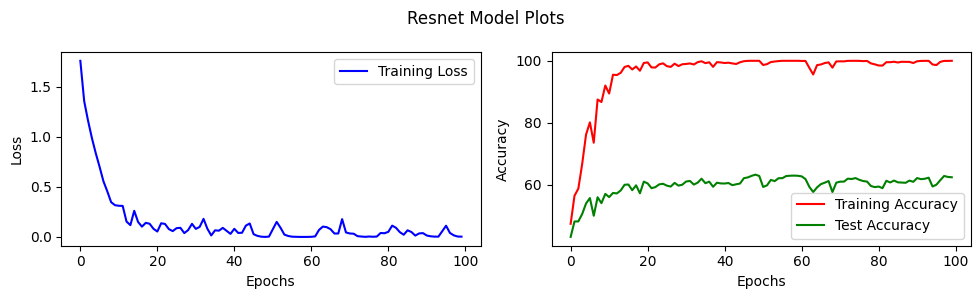

In [9]:
resnet = ResnetModel(itr=100, learningRate=0.001, mixup=False)
trainingLoss,trainAcc,testAcc = resnet.train(trainData=train_loader,testData=test_loader)
acc = resnet.test(testData=test_loader)
print('Final Accuracy of Resnet Model without Augmentation - ',acc)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot training loss
ax1.plot(trainingLoss, 'b-', label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracies
ax2.plot(trainAcc, 'r-', label='Training Accuracy')
ax2.plot(testAcc, 'g-', label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('Resnet Model Plots')
plt.tight_layout()
plt.show()

# 2. (4 pts) Mixup augmentation 
is based on the paper https://arxiv.org/pdf/1710.09412.pdf. As the
name suggests, it mixes a pair of training examples (both inputs and labels). Given a pair of training
example (x1, y1), (x2, y2), we obtain the augmented training example (x, y) via
x = λx1 + (1 − λ)x2 y = λy1 + (1 − λ)y2
where mixing parameter λ has β distribution1 with parameter α.,<br>
**TODO**: Implement mixup and report the results for α = 0.2 and α = 0.4. Note that, in each minibatch,
all training examples should have mixup transformation before gradient calculation (e.g. from original
minibatch obtain a new minibatch by mixing random pairs of training examples).

---



---



Final Accuracy with Mixup Augmentation-  64.36


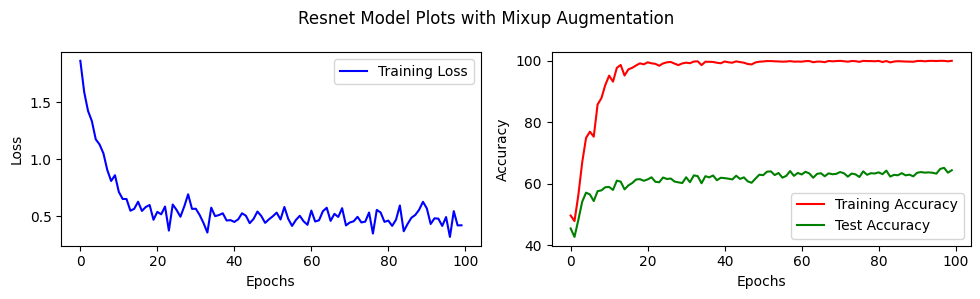

Final Accuracy with Mixup Augmentation-  65.78


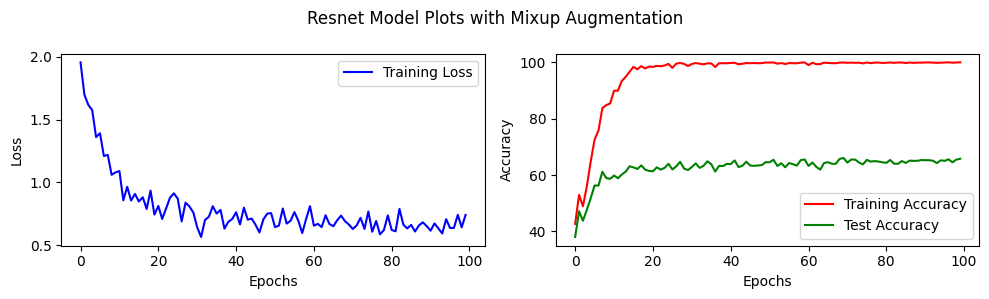

In [10]:
Alpha=[0.2,0.4]
for alpha in Alpha:
  resnet = ResnetModel(itr=100, learningRate=0.001, alpha=alpha, mixup=True)
  trainingLoss,trainAcc,testAcc = resnet.train(trainData=train_loader,testData=test_loader)
  acc = resnet.test(testData=test_loader)
  print('Final Accuracy with Mixup Augmentation- ',acc)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

  # Plot training loss
  ax1.plot(trainingLoss, 'b-', label='Training Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()

  # Plot accuracies
  ax2.plot(trainAcc, 'r-', label='Training Accuracy')
  ax2.plot(testAcc, 'g-', label='Test Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  fig.suptitle('Resnet Model Plots with Mixup Augmentation')
  plt.tight_layout()
  plt.show()

# 3. (4 pts) Cutout augmentation 
is based on the paper https://arxiv.org/pdf/1708.04552.pdf. For
each training image with 50% probability you keep the image intact. With 50% probability, select a
random pixel which serves as the center of your cutout mask. Then, set the square mask of size K ×K
pixels around this center pixel to be zero. Note that part of the mask is allowed to be outside of the
image. For visualization, see Figure 1 of the paper.<br>
**TODO**: Implement and use cutout augmentation with K = 16 and report the results.


---



---



In [13]:
K=16
def cutoutData(Data,K):
  cutout_augmented_data = []
  cutout_augmented_labels = []

  # Iterate over each example in the dataset
  for i in range(len(Data)):
      image, label = Data[i]

      # Check if cutout augmentation should be applied
      if np.random.rand() < 0.5:
          cutout_augmented_data.append(image)  # Keep the image intact
          cutout_augmented_labels.append(label)
      else:
          h, w = image.shape[1:]

          # Randomly select the center of the cutout mask
          center_h = np.random.randint(K // 2, h - K // 2)
          center_w = np.random.randint(K // 2, w - K // 2)

          # Create the cutout mask
          mask = np.ones((h, w), dtype=np.float32)
          mask[center_h - K // 2: center_h + K // 2, center_w - K // 2: center_w + K // 2] = 0.0

          # Apply the cutout mask to the image
          masked_image = image * mask

          # Append the masked image and label to the augmented data and labels lists
          cutout_augmented_data.append(masked_image)
          cutout_augmented_labels.append(label)

  cutout_train_dataset = torch.utils.data.TensorDataset(torch.stack(cutout_augmented_data), torch.tensor(cutout_augmented_labels))
  cutout_train_loader = torch.utils.data.DataLoader(cutout_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  return cutout_train_dataset,cutout_train_loader

In [ ]:
K=16
cutout_train_dataset,cutout_train_loader = cutoutData(custom_train_dataset,K)
# for image,label in cutout_train_loader:
#   print(image.shape)

Final Accuracy -  59.65


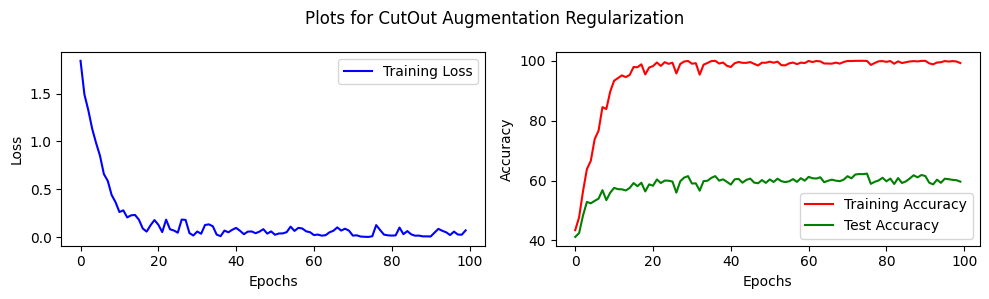

In [ ]:
resnet = ResnetModel(itr=100, learningRate=0.001, mixup=False)
trainingLoss,trainAcc,testAcc = resnet.train(trainData=cutout_train_loader,testData=test_loader)
acc = resnet.test(testData=test_loader)
print('Final Accuracy - ',acc)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot training loss
ax1.plot(trainingLoss, 'b-', label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracies
ax2.plot(trainAcc, 'r-', label='Training Accuracy')
ax2.plot(testAcc, 'g-', label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('Plots for CutOut Augmentation Regularization')
plt.tight_layout()
plt.show()

# 4. (4 pts) Standard augmentation 
applies horizontal flip and random shifts. See the website https://
machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-for illustrations. Given an input image, first you shift it left-right and up-down as follows. Pick two
independent integers k1, k2 uniformly between [−K,K] range. Move image upwards by k1 and rightwards
by k2 pixels (negative value means downwards and leftwards). Zero pad the missing pixels. After
this random shift, with 50% probability, apply a horizontal flip on the image.<br>
**TODO**: Implement standard augmentation with K = 4 and report the results2.

---



---



In [14]:
def StandardAugmentation(Data,K):
  import torch
  import torchvision.transforms as transforms

  # Custom transformation
  class CustomAugmentation(object):
      def __call__(self, image):
          # Zero-padding
          padded_image = transforms.functional.pad(image, K)

          # Random crop
          cropped_image = transforms.functional.random_crop(padded_image, (32, 32))

          return cropped_image

  # Apply standard augmentation to your dataset
  custom_transform = transforms.Compose([
      CustomAugmentation(),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ToTensor()
  ])

  standard_train_dataset = Data
  standard_train_dataset.transform = custom_transform
  standard_train_loader = torch.utils.data.DataLoader(standard_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
  return standard_train_dataset, standard_train_loader

In [ ]:
K=4
standard_train_dataset, standard_train_loader = StandardAugmentation(custom_train_dataset,K)
# for image,label in standard_train_loader:
#   print(image.shape)

Final Accuracy -  62.27


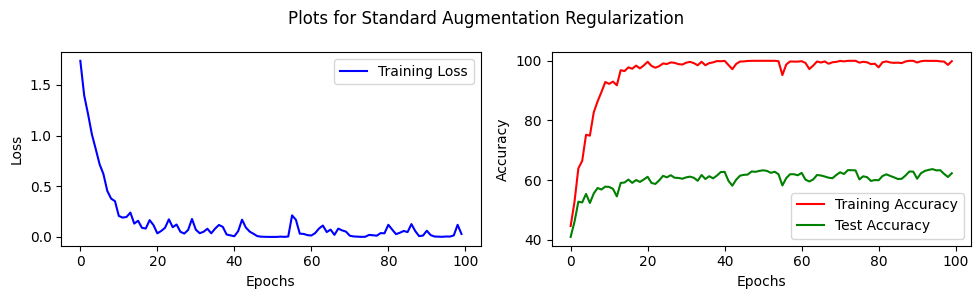

In [ ]:
resnet = ResnetModel(itr=100, learningRate=0.001, mixup=False)
trainingLoss,trainAcc,testAcc = resnet.train(trainData=standard_train_loader,testData=test_loader)
acc = resnet.test(testData=test_loader)
print('Final Accuracy - ',acc)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot training loss
ax1.plot(trainingLoss, 'b-', label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracies
ax2.plot(trainAcc, 'r-', label='Training Accuracy')
ax2.plot(testAcc, 'g-', label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('Plots for Standard Augmentation Regularization')
plt.tight_layout()
plt.show()

# 5. (3 pts) Combine all augmentations together.
 First apply standard and cutout augmentations on the
training images and then apply mixup to blend them. For mixup, use the parameter α that has higher
test accuracy. Report the results. Does combining improve things further?

---



---



In [15]:
K=16
cutout_train_dataset,cutout_train_loader = cutoutData(custom_train_dataset,K)
K=4
combined_train_dataset, combined_train_loader = StandardAugmentation(cutout_train_dataset,K)
# for image,label in combined_train_loader:
#   print(image.shape)

Final Accuracy for combined Data Augmentation-  60.7


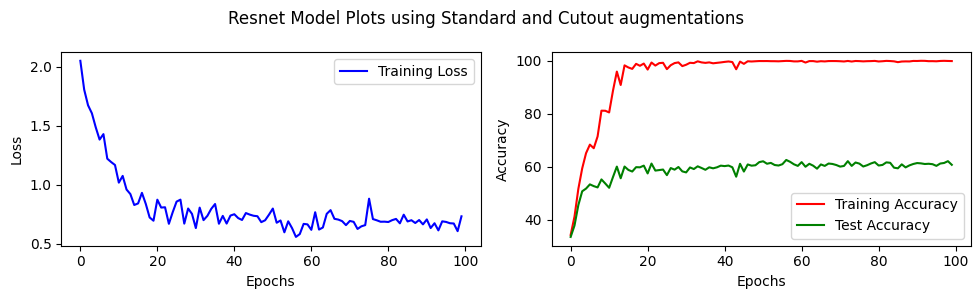

In [16]:
resnet = ResnetModel(itr=100, learningRate=0.001, alpha=0.4, mixup=True)
trainingLoss,trainAcc,testAcc = resnet.train(trainData=combined_train_loader,testData=test_loader)
acc = resnet.test(testData=test_loader)
print('Final Accuracy for combined Data Augmentation- ',acc)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot training loss
ax1.plot(trainingLoss, 'b-', label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracies
ax2.plot(trainAcc, 'r-', label='Training Accuracy')
ax2.plot(testAcc, 'g-', label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('Resnet Model Plots using Standard and Cutout augmentations')
plt.tight_layout()
plt.show()

# 6. (2 pts) Comment on the role of data augmentation. 
How does it affect test accuracy, train accuracy
and the convergence of optimization? Is test accuracy higher? Does training loss converge faster?

---



---



**Test Accuracy:** In general right data augementation make the model more robust in generalizing on unseen data. Therefore it can improve test accuracy.

* Mixup :- This theoratically should make classification models more 
generalizable and should therefore increase accuracy, which is happening here. It has increased the accuracy from 62.42% (baseline model without augmentation) to 65.78%

* Cutout :- Potentially it should improve test accuracy by making the model more resilient to occlusions or missing information in the test set. But, This hasn't improved the accuracy of the model, infact it has reduced the accuracy to 59.65%

* Standard :- Ideally should improve test accuracy by exposing the model to a wider range of variations. But, in this problem It didn't have any significant impact on accuracy (62.27%) as I am expectting the test data doesn't have any rotated images.

**Train Accuracy:**  It is common for train accuracy to decrease slightly when using data augmentation. This occurs because the augmented data introduces additional challenging examples, which the model may initially struggle to classify correctly. This can be slightly observed in the Training Accuracy Ploats above. The traning accuracy curve is sligtly stretched when applied augmentations to data, whereas it is slightly steeper without any augmentations.

**Convergence of Optimization:** Theoratically, data augmentation can have a positive effect on the convergence of optimization during training. By introducing more diverse examples, data augmentation helps prevent overfitting by regularizing the model. Regularization encourages the model to learn more generalizable representations and can prevent the optimization process from getting stuck in local minima. As a result, training loss may converge faster or reach a lower value with data augmentation.

It is hard to observe from the above plots if the training loss is convering faster when data augmentations were applied.